In [37]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import comb

In [38]:
class BCH_Code:
    """
    Generic class for BCH cyclic codes.
    Parameters n, k, t, generator polynomial g_poly.
    """
    def __init__(self, n, k, t, g_poly):
        self.n = n
        self.k = k
        self.t = t
        
        # parity polynomial h(x) = (x^n - 1) / g(x)
        h_poly = self._poly_div_gf2(self.n, g_poly)
        
        # parity check matrix H
        self.num_checks = self.n - self.k
        self.H = np.zeros((self.num_checks, self.n), dtype=np.uint8)
        h_rev = np.flip(h_poly)
        for r in range(self.num_checks):
            self.H[r, r:r+len(h_rev)] = h_rev

        # syndrome table
        self.lookup = {}
        
        # 0 Errors
        self.lookup[self._key(np.zeros(self.num_checks, dtype=np.uint8))] = np.zeros(self.n, dtype=np.uint8)
        
        # 1 to t Errors
        for w in range(1, self.t + 1):
            for locs in combinations(range(self.n), w):
                e = np.zeros(self.n, dtype=np.uint8)
                e[list(locs)] = 1
                
                syn = (self.H @ e) % 2
                self.lookup[self._key(syn)] = e

    def theoretical_pL(self, p):
        """Calculates theoretical failure rate (errors > t)."""
        # Sum probabilities of k errors where k is from t+1 to n
        return sum(comb(self.n, k) * (p**k) * ((1-p)**(self.n-k)) 
                   for k in range(self.t + 1, self.n + 1))

    def _poly_div_gf2(self, n, divisor):
        """Computes (x^n + 1) / divisor in GF(2)."""
        dividend = np.zeros(n + 1, dtype=np.uint8)
        dividend[0] = 1; dividend[n] = 1
        quotient = np.zeros(n + 1, dtype=np.uint8)
        remainder = dividend.copy()
        deg_div = len(divisor) - 1
        
        while True:
            non_zeros = np.where(remainder)[0]
            if len(non_zeros) == 0: break
            deg_rem = non_zeros[-1]
            if deg_rem < deg_div: break
            
            diff = deg_rem - deg_div
            quotient[diff] = 1
            shifted_divisor = np.zeros(len(remainder), dtype=np.uint8)
            shifted_divisor[diff : diff + len(divisor)] = divisor
            remainder = (remainder + shifted_divisor) % 2
            
        last_nonzero = np.max(np.where(quotient)[0])
        return quotient[:last_nonzero+1]

    def _key(self, array):
        return array.tobytes()

In [39]:
def run_simulation(bch, probs):
    """
    Runs the simulation using the parameters stored in the 'bch' object.
    """
    results = []
    theory = []
    
    print(f"{'p_phys':<10} | {'p_logical':<12} | {'theory':<12}")
    
    for p in probs:
        # circuit
        circuit = stim.Circuit()
        circuit.append("R", range(bch.n))          # Uses bch.n
        circuit.append("X_ERROR", range(bch.n), p) # Uses bch.n
        circuit.append("M", range(bch.n))          # Uses bch.n
        
        shots = 100_000
        sampler = circuit.compile_sampler()
        samples = sampler.sample(shots=shots)
        
        # decoding
        syndromes = (samples @ bch.H.T) % 2
        
        fails = 0
        for i in range(shots):
            syn_key = syndromes[i].tobytes()
            
            if syn_key in bch.lookup:
                correction = bch.lookup[syn_key]
                final_state = (samples[i] + correction) % 2
                
                # failure
                if np.any(final_state):
                    fails += 1
            else:
                fails += 1
                
        p_sim = fails / shots
        p_th = bch.theoretical_pL(p)
        
        results.append(p_sim)
        theory.append(p_th)
        
        print(f"{p:<10.4f} | {p_sim:<12.6f} | {p_th:<12.6f}")

    return results, theory

p_phys     | p_logical    | theory      
0.0010     | 0.002030     | 0.001875    
0.0020     | 0.007590     | 0.007204    
0.0030     | 0.015460     | 0.015571    
0.0050     | 0.040970     | 0.039931    
0.0080     | 0.090760     | 0.090809    
0.0100     | 0.131760     | 0.131245    
0.0200     | 0.358630     | 0.359875    
0.0300     | 0.568800     | 0.567273    
0.0400     | 0.722830     | 0.723054    


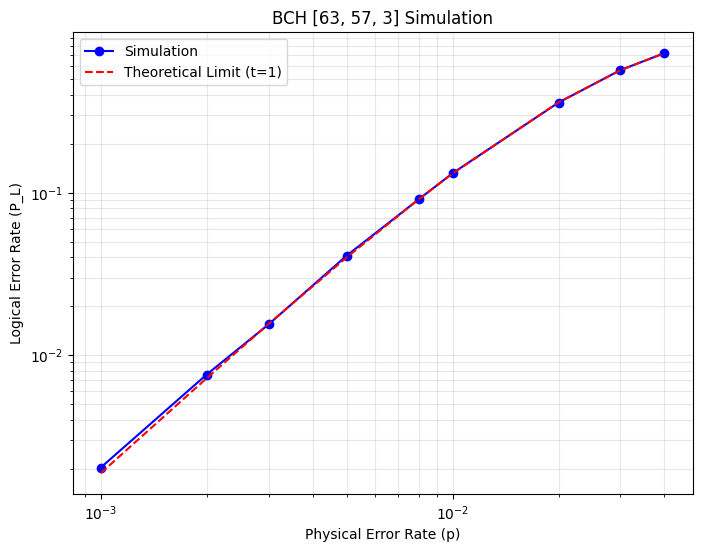

In [41]:
if __name__ == "__main__":
    N = 15
    K = 57
    T = 1
    
    # low to high
    G_POLY = np.array([1, 1, 0, 0, 0, 0, 1], dtype=np.uint8) 

    my_code = BCH_Code(n=N, k=K, t=T, g_poly=G_POLY)
    probabilities = [0.001, 0.002, 0.003, 0.005, 0.008, 0.01, 0.02, 0.03, 0.04]
    sim_res, th_res = run_simulation(my_code, probabilities)
    
    # plot
    plt.figure(figsize=(8, 6))
    plt.loglog(probabilities, sim_res, 'o-', color='blue', label='Simulation')
    plt.loglog(probabilities, th_res, 'r--', label=f'Theoretical Limit (t={T})')
    plt.xlabel('Physical Error Rate (p)')
    plt.ylabel('Logical Error Rate (P_L)')
    plt.title(f'BCH [{N}, {K}, {2*T+1}] Simulation')
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()